In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve  # 画学习曲线的类
from sklearn.model_selection import ShuffleSplit  # 设定交叉验证模式的类
from sklearn.ensemble import RandomForestClassifier

plt.rcParams['font.sans-serif'] = 'Microsoft YaHei'
plt.rcParams['axes.unicode_minus'] = False
plt.style.use("ggplot")

# 数据探索

In [2]:
data = pd.read_csv("./data/随机森林-数据集/glass/glass.csv")

In [3]:
data.head(4)

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1


In [4]:
# 7个种类
data["Type"].unique()

array([1, 2, 3, 5, 6, 7], dtype=int64)

In [5]:
# 数据没有null
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


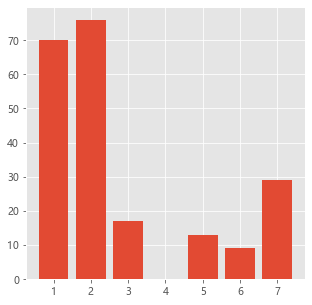

In [6]:
types = data.loc[:, ["Type", "RI"]].groupby("Type").count()
plt.figure(figsize=(5, 5))
plt.bar(types.index, types.values.flatten())
plt.xticks(range(1, 8))
plt.show()

**因为数据量较少，将不使用袋外数据集**

# 数据预处理

In [7]:
# 划分训练集合
x_train, x_test, y_train, y_test = train_test_split(
    data.iloc[:, 0:9], data.iloc[:, -1], test_size=0.25)

In [8]:
x_train.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
196,1.51556,13.87,0.00,2.54,73.23,0.14,9.41,0.81,0.01
56,1.51215,12.99,3.47,1.12,72.98,0.62,8.35,0.00,0.31
73,1.51631,13.34,3.57,1.57,72.87,0.61,7.89,0.00,0.00
63,1.52227,14.17,3.81,0.78,71.35,0.00,9.69,0.00,0.00
40,1.51793,12.79,3.50,1.12,73.03,0.64,8.77,0.00,0.00


In [9]:
y_train.head()

196    7
56     1
73     2
63     1
40     1
Name: Type, dtype: int64

# 训练模型

In [10]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

In [11]:
superpa = list()
test_score = list()
for i in range(0, 200, 5):
    rfc = RandomForestClassifier(
        n_estimators=i+1, n_jobs=-1, random_state=42)  # 对不同 n_estimators 进行建模
    rfc_s = cross_val_score(rfc, x_train, y_train, cv=cv, n_jobs=-1).mean()
    superpa.append(rfc_s)

0.796875 51


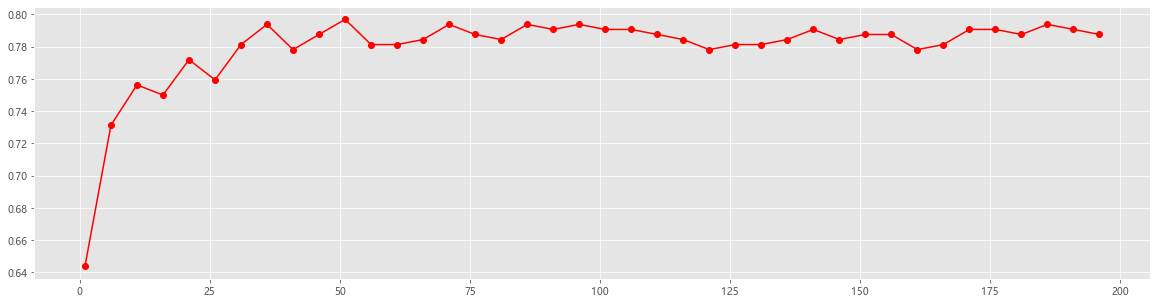

In [12]:
# 所有评分
# list(zip(superpa,range(1,201,5)))

# 打印出：最高精确度取值，max(superpa))+1指的是森林数目的数量的索引
best_about_estimator = range(1, 201, 5)[superpa.index(max(superpa))]
print(max(superpa), best_about_estimator)

# 画图
plt.figure(figsize=[20, 5])
plt.plot(range(1, 201, 5), superpa, "-o", color="r")
plt.show()

 细化学习曲线

In [13]:
range2 = range(best_about_estimator-10, best_about_estimator+10)

In [14]:
# 细化学习曲线

superpa2 = []
for i in range2:
    rfc = RandomForestClassifier(
        n_estimators=i, n_jobs=-1, random_state=42)  # 对不同 n_estimators 进行建模
    rfc_s = cross_val_score(rfc, x_train, y_train, cv=cv, n_jobs=-1).mean()
    superpa2.append(rfc_s)

0.803125 53


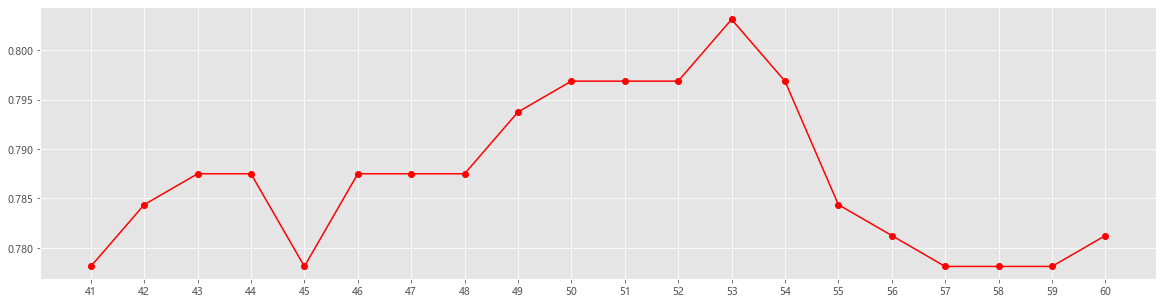

In [15]:
# 所有评分
# list(zip(superpa2,range2))

best_n_estimator = range2[superpa2.index(max(superpa2))]  # 最好的n_estimator
print(max(superpa2), best_n_estimator)


# 画图
plt.figure(figsize=[20, 5])
plt.xticks(range2)
plt.plot(range2, superpa2, "-o", color="r")
plt.show()

确定最好的n_estimator

In [16]:
# 尝试网格搜索对随机森林的其它参数进行调参（max_depth, max_features, min_samples_leaf）

# 因为算力原因，这里只对max_depth进行调整

param_grid = {'max_depth': np.arange(1, 20, 1)}
rfc = RandomForestClassifier(
    n_estimators=best_n_estimator, random_state=42, n_jobs=-1)
GS = GridSearchCV(rfc, param_grid, cv=cv, n_jobs=-1)  # 网格搜索
GS.fit(x_train, y_train)

GS.best_params_

{'max_depth': 9}

**因为算力原因这里就不再通过网格搜索跑其他参数**

In [17]:
# 使用训练好的参数建模，进行预测

rfc_best = RandomForestClassifier(n_estimators=best_n_estimator, n_jobs=-1,
                                  random_state=42, max_depth=GS.best_params_["max_depth"])

In [18]:
rfc_best = rfc_best.fit(x_train, y_train)

In [29]:
print("n_estimators调为%d,max_depth调为%d，最后得分为：" %
      (best_n_estimator, GS.best_params_["max_depth"]))
rfc_best.score(x_test, y_test)

n_estimators调为53,max_depth调为9，最后得分为：


0.7777777777777778

In [28]:
list(zip(*(rfc_best.feature_importances_, data.columns[0:-1])))

[(0.1609698811228881, 'RI'),
 (0.09947669507269029, 'Na'),
 (0.15726623599969172, 'Mg'),
 (0.15377317705039814, 'Al'),
 (0.0778560092323443, 'Si'),
 (0.08657704982934546, 'K'),
 (0.10179992599831889, 'Ca'),
 (0.12444835564623934, 'Ba'),
 (0.037832670048083834, 'Fe')]